<center><a target="_blank" href="https://academy.constructor.org/"><img src=https://lh3.googleusercontent.com/d/1EmH3Jks5CpJy0zK3JbkvJZkeqWtVcxhB width="500" style="background:none; border:none; box-shadow:none;" /></a> </center>
<hr />

# <h1 align="center"> Exercise 1: Classification II </h1>

<hr />
<center>Constructor Academy, 2024</center>

# Pirate Attacks

You are provided with a dataset on vessels that have been attacked by pirates. Your task is to predict whether an attack is likely to be successful.

Compare the performance of KNN, Naive Bayes, SVM and Random Forrest.

- Clean and preprocess the data. This includes:

    - Select features. Caution: Some features might lead to “data leakage” …
    - One-hot encode categorical variables.
    - How do you handle the date?
    - Aggregate categories with few occurrences.
- Run all four models on the data
- Tune the models and identify the best performing one

## Bonus

Using a pipeline makes building a full-fledged hyperparameter optimization much easier. Have a look at GridSearchCV and RandomSearchCV.

## Import Libraries and Preprocess the Data

In [1]:
%load_ext autoreload
%autoreload 2

#%load_ext lab_black

In [2]:
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm as cm

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV,
)
from sklearn import preprocessing
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_squared_error,
    f1_score,
)
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

In [3]:
plt.style.use("seaborn-v0_8")

In [5]:
data = pd.read_csv("../data/pirate_data.csv", delimiter=",", index_col=0)

<b> Goal:</b> Predict Pirate Attack Success

In [6]:
data.head()

,DATETIME (LOCAL),DATETIME (UTC),DATE (LT),DATE (UTC),REGION,COUNTRY,INCIDENT TYPE,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,LAT,LONG,TIMEZONE,TIME OF DAY,ATTACKS,ATTACK SUCCESS
1,2016-01-30 23:34:00,2016-01-30 22:34:00,2016-01-30,2016-01-30,WEST AFRICA,NIGERIA,"FAILED ATTACK, HIJACKING",CONTAINER SHIP,0,OFF SHORE,3.000000,6.250000,Africa/Lagos,EVENING,1,0
2,2016-01-29 23:40:00,2016-01-29 22:40:00,2016-01-29,2016-01-29,WEST AFRICA,NIGERIA,KIDNAP/RANSOM AT SEA,PRODUCT TANKER,0,OFF SHORE,2.500000,5.750000,Africa/Lagos,EVENING,1,1
3,2016-01-28 03:00:00,2016-01-28 02:00:00,2016-01-28,2016-01-28,SOUTH ASIA,INDIA,"FAILED ATTACK, ROBBERY",PRODUCT TANKER,0,ANCHORAGE,22.816667,70.116667,Asia/Kolkata,NIGHT,1,0
4,NaN,NaN,2016-01-27,2016-01-27,HORN OF AFRICA/ GULF OF ADEN,SOMALIA,SUSPICIOUS ACTIVITY AT SEA,NaN,0,OFF SHORE,13.998747,54.112792,Asia/Riyadh,UNKNOWN,1,0
5,2016-01-25 23:55:00,2016-01-25 22:55:00,2016-01-25,2016-01-25,SOUTH AMERICA,VENEZUELA,THEFT AT ANCHORAGE,GENERAL CARGO VESSEL,0,ANCHORAGE,10.267500,-63.432500,America/Caracas,EVENING,1,1


* 'DATETIME (LOCAL)': Leave out as it's too granular
* 'DATETIME (UTC)': Leave out as it's too granular
* 'DATE (LT)': Leave it in for the time being, but only focus on months as it's too granular
* 'DATE (UTC)': Leave out, as we only need one type of date information (LT) here
* 'REGION': Leave it in
* 'COUNTRY': Leave it out, we have region but good to try with country as well
* 'INCIDENT TYPE': Leave out, it constitutes data leakage
* 'VESSEL TYPE': Leave it in
* 'MAERSK?': Leave it out, a specific shipping company is not the focus here
* 'VESSEL ACTIVITY LOCATION': Leave it in
* 'LAT': Leave out as it's too granular, we have region or country for this
* 'LONG': Leave out as it's too granular, we have region or country for this
* 'TIMEZONE': Leave out
* 'TIME OF DAY': leave it in, but convert to numbers
* 'ATTACKS': could be left out as it's all ones anyway (see below), but we'll leave it in for data exploration
* 'ATTACK SUCCESS': leave it in (this will be the target variable, it is based on 'INCIDENT TYPE')

### Drop useless columns and leakage (incident type)
#### Columns chosen based on common sence

In [7]:
data.columns

Index(['DATETIME (LOCAL)', 'DATETIME (UTC)', 'DATE (LT)', 'DATE (UTC)',
       'REGION', 'COUNTRY', 'INCIDENT TYPE', 'VESSEL TYPE', 'MAERSK?',
       'VESSEL ACTIVITY LOCATION', 'LAT', 'LONG', 'TIMEZONE', 'TIME OF DAY',
       'ATTACKS', 'ATTACK SUCCESS'],
      dtype='object')

In [8]:
data = data.drop(columns=[
        "DATETIME (LOCAL)",
        "DATETIME (UTC)",
        "DATE (UTC)",
        "COUNTRY",
        "MAERSK?",
        "LAT",
        "LONG",
        "TIMEZONE",
        "INCIDENT TYPE",])
data.columns

Index(['DATE (LT)', 'REGION', 'VESSEL TYPE', 'VESSEL ACTIVITY LOCATION',
       'TIME OF DAY', 'ATTACKS', 'ATTACK SUCCESS'],
      dtype='object')

#### Check for missing values

In [9]:
data.isna().sum()

DATE (LT)                     0
REGION                        0
VESSEL TYPE                 164
VESSEL ACTIVITY LOCATION    126
TIME OF DAY                   0
ATTACKS                       0
ATTACK SUCCESS                0
dtype: int64

In [10]:
data.shape

(802, 7)

In [11]:
data["VESSEL ACTIVITY LOCATION"].value_counts()

VESSEL ACTIVITY LOCATION
OFF SHORE    421
ANCHORAGE    198
BERTH         57
Name: count, dtype: int64

In [12]:
data["VESSEL TYPE"].value_counts()

VESSEL TYPE
BULK CARRIER                          134
PRODUCT TANKER                        107
CONTAINER SHIP                         60
TUG                                    34
TANKER                                 34
FISHING VESSEL                         33
MERCHANT VESSEL                        30
GENERAL CARGO VESSEL                   28
CRUDE OIL TANKER                       28
SUPPLY VESSEL                          25
PASSENGER VESSEL                       25
CHEMICAL TANKER                        15
LPG TANKER                             10
UNKNOWN                                10
VEHICLE CARRIER                         7
TRAWLER                                 7
BARGE                                   5
DREDGER                                 4
FISHING TRAWLER                         4
HEAVY LIFT VESSEL                       3
REEFER                                  3
NAVAL VESSEL                            2
FISHING DHOW                            2
RESEARCH VESSEL       

In [13]:
data[data["VESSEL TYPE"] == "UNKNOWN"]

,DATE (LT),REGION,VESSEL TYPE,VESSEL ACTIVITY LOCATION,TIME OF DAY,ATTACKS,ATTACK SUCCESS
274,2015-09-21,SOUTH EAST ASIA,UNKNOWN,BERTH,UNKNOWN,1,1
310,2015-08-25,SOUTH ASIA,UNKNOWN,OFF SHORE,UNKNOWN,1,0
363,2015-07-27,WEST AFRICA,UNKNOWN,OFF SHORE,MORNING,1,0
370,2015-07-26,SOUTH EAST ASIA,UNKNOWN,OFF SHORE,UNKNOWN,1,1
378,2015-07-16,WEST AFRICA,UNKNOWN,OFF SHORE,EVENING,1,1
450,2015-06-03,WEST AFRICA,UNKNOWN,ANCHORAGE,MORNING,1,0
466,2015-05-20,WEST AFRICA,UNKNOWN,BERTH,MORNING,1,1
519,2015-04-24,WEST AFRICA,UNKNOWN,OFF SHORE,EVENING,1,0
597,2015-03-05,WEST AFRICA,UNKNOWN,OFF SHORE,EVENING,1,1
626,2015-02-13,WEST AFRICA,UNKNOWN,OFF SHORE,MORNING,1,1


VESSEL TYPE and VESSEL ACTIVITY LOCATION have missing values (around 15%), we still can delete them. 

Better options would be: 
  - impute the data with one of sklearn.impute methods. Beware when impute categorical data.
  - put NaNs into Unknown category and handle it with OneHotEncoder. 


In [14]:
data = data.fillna(value="UNKNOWN")

In [15]:
data.shape

(802, 7)

In [16]:
data["VESSEL ACTIVITY LOCATION"].value_counts()

VESSEL ACTIVITY LOCATION
OFF SHORE    421
ANCHORAGE    198
UNKNOWN      126
BERTH         57
Name: count, dtype: int64

In [17]:
data["VESSEL TYPE"].value_counts()

VESSEL TYPE
UNKNOWN                               174
BULK CARRIER                          134
PRODUCT TANKER                        107
CONTAINER SHIP                         60
TUG                                    34
TANKER                                 34
FISHING VESSEL                         33
MERCHANT VESSEL                        30
CRUDE OIL TANKER                       28
GENERAL CARGO VESSEL                   28
PASSENGER VESSEL                       25
SUPPLY VESSEL                          25
CHEMICAL TANKER                        15
LPG TANKER                             10
VEHICLE CARRIER                         7
TRAWLER                                 7
BARGE                                   5
FISHING TRAWLER                         4
DREDGER                                 4
REEFER                                  3
HEAVY LIFT VESSEL                       3
NAVAL VESSEL                            2
FISHING DHOW                            2
RESEARCH VESSEL       

#### Further feature engineering

We see that column "VESSEL TYPE" has too many categories with less observations per category so we group them together.
For now we create a category "OTHER" and combine all categories that have less than 20 observations.
Better option would be to make much more meaningful group of categories.

In [18]:
def isOther(cell, contain_list):
    if cell in contain_list:
        return cell
    return "OTHER"

In [19]:
vessel_list = (
    data["VESSEL TYPE"].value_counts().index[data["VESSEL TYPE"].value_counts() > 20]
)

In [20]:
data["VESSEL TYPE"] = data["VESSEL TYPE"].apply(lambda row: isOther(row, vessel_list))

In [21]:
data["VESSEL TYPE"].value_counts()

VESSEL TYPE
UNKNOWN                 174
BULK CARRIER            134
PRODUCT TANKER          107
OTHER                    90
CONTAINER SHIP           60
TUG                      34
TANKER                   34
FISHING VESSEL           33
MERCHANT VESSEL          30
CRUDE OIL TANKER         28
GENERAL CARGO VESSEL     28
PASSENGER VESSEL         25
SUPPLY VESSEL            25
Name: count, dtype: int64

In [22]:
data.columns

Index(['DATE (LT)', 'REGION', 'VESSEL TYPE', 'VESSEL ACTIVITY LOCATION',
       'TIME OF DAY', 'ATTACKS', 'ATTACK SUCCESS'],
      dtype='object')

Which other columns we can delete? 'ATTACKS' column has only ones, so it does not provide any information. 

In [23]:
data["ATTACKS"].value_counts()

ATTACKS
1    802
Name: count, dtype: int64

The 'DATE (LT)' itself also is useless, but we cab extract valuable information out of it:

In [24]:
data["MONTH"] = pd.DatetimeIndex(data["DATE (LT)"]).month.astype(str)
data["WEEKDAY"] = pd.DatetimeIndex(data["DATE (LT)"]).weekday.astype(str)
data.head()

,DATE (LT),REGION,VESSEL TYPE,VESSEL ACTIVITY LOCATION,TIME OF DAY,ATTACKS,ATTACK SUCCESS,MONTH,WEEKDAY
1,2016-01-30,WEST AFRICA,CONTAINER SHIP,OFF SHORE,EVENING,1,0,1,5
2,2016-01-29,WEST AFRICA,PRODUCT TANKER,OFF SHORE,EVENING,1,1,1,4
3,2016-01-28,SOUTH ASIA,PRODUCT TANKER,ANCHORAGE,NIGHT,1,0,1,3
4,2016-01-27,HORN OF AFRICA/ GULF OF ADEN,UNKNOWN,OFF SHORE,UNKNOWN,1,0,1,2
5,2016-01-25,SOUTH AMERICA,GENERAL CARGO VESSEL,ANCHORAGE,EVENING,1,1,1,0


In [25]:
data = data.drop(columns=["DATE (LT)", "ATTACKS"])
data.columns

Index(['REGION', 'VESSEL TYPE', 'VESSEL ACTIVITY LOCATION', 'TIME OF DAY',
       'ATTACK SUCCESS', 'MONTH', 'WEEKDAY'],
      dtype='object')

In [26]:
# Separate the feature variables X and the target variable y (Successful Attack):
X = data.drop(["ATTACK SUCCESS"], axis=1)
y = data["ATTACK SUCCESS"]

In [27]:
X.head()

,REGION,VESSEL TYPE,VESSEL ACTIVITY LOCATION,TIME OF DAY,MONTH,WEEKDAY
1,WEST AFRICA,CONTAINER SHIP,OFF SHORE,EVENING,1,5
2,WEST AFRICA,PRODUCT TANKER,OFF SHORE,EVENING,1,4
3,SOUTH ASIA,PRODUCT TANKER,ANCHORAGE,NIGHT,1,3
4,HORN OF AFRICA/ GULF OF ADEN,UNKNOWN,OFF SHORE,UNKNOWN,1,2
5,SOUTH AMERICA,GENERAL CARGO VESSEL,ANCHORAGE,EVENING,1,0


In [28]:
y.head()

1    0
2    1
3    0
4    0
5    1
Name: ATTACK SUCCESS, dtype: int64

### Perform Train-Test Split on the final dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=123
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(601, 6)
(201, 6)
(601,)
(201,)


### Introduce Encoding 

We only have categorical features left so we have only encoding and not scaling

In [30]:
ohe = preprocessing.OneHotEncoder(handle_unknown="ignore")

#  Running models

## KNN

In [31]:
# Call model into variable
knn = KNeighborsClassifier(n_neighbors=5)
knn_pipe = Pipeline([("one_hot_enc", ohe), ("estimator", knn)])

In [32]:
knn_score = np.mean(cross_val_score(knn_pipe, X_train, y_train, scoring="f1", cv=4))
knn_score

0.7323730023093273

## Naive Bayes

In [33]:
# Choosing Bernoulli, as input variables are binary after One-Hot-Encoding
# Call model into variable
nb = BernoulliNB()

nb_pipe = Pipeline([("one_hot_enc", ohe), ("estimator", nb)])

In [34]:
nb_score = np.mean(cross_val_score(nb_pipe, X_train, y_train, scoring="f1", cv=4))
nb_score

0.7031580568024148

## SVM

### Linear Support Vector Classification

In [35]:
# Call model into variable
svm = LinearSVC()
svm_pipe = Pipeline([("one_hot_enc", ohe), ("estimator", svm)])

In [36]:
svm_score = np.mean(cross_val_score(svm_pipe, X_train, y_train, scoring="f1", cv=4))
svm_score

0.745813062350756

### Support Vector Classification with Radial Basis Function

In [37]:
# Call model into variable
svm_rbf = SVC(kernel="rbf", gamma="scale")
svm_rbf_pipe = Pipeline([("one_hot_enc", ohe), ("estimator", svm_rbf)])

In [38]:
svm_rbf_score = np.mean(
    cross_val_score(svm_rbf_pipe, X_train, y_train, scoring="f1", cv=4)
)
svm_rbf_score

0.7567515686016411

## Random Forest

In [39]:
rfc = RandomForestClassifier()
rfc_pipe = Pipeline([("one_hot_enc", ohe), ("estimator", rfc)])

In [40]:
rfc_score = np.mean(cross_val_score(rfc_pipe, X_train, y_train, scoring="f1", cv=4))
rfc_score

0.7361439251143959

## Let's find the best model 

In [41]:
models = ["knn", "nb", "svm", "svm_rbf", "rfc"]
scores = [knn_score, nb_score, svm_score, svm_rbf_score, rfc_score]

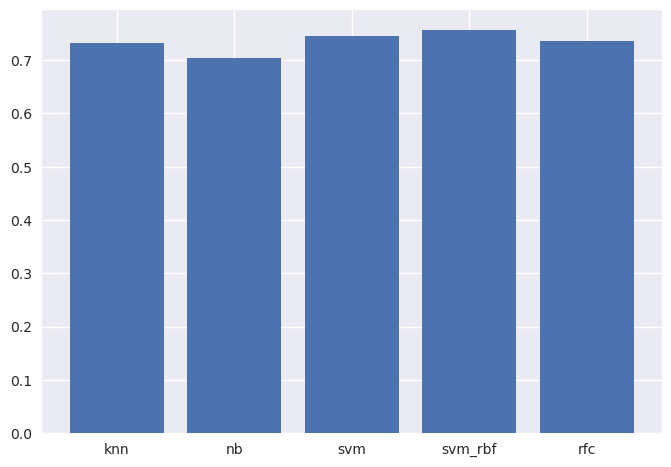

In [42]:
plt.bar(models, scores)
plt.show()

In [43]:
print(
    f"The best score is: {np.max(scores)} \nThe best model is: {models[scores.index(np.max(scores))]}"
)

The best score is: 0.7567515686016411 
The best model is: svm_rbf


# Results of the best model

## Classification report

In [44]:
# Train model
svm_rbf_pipe.fit(X_train, y_train)
print(svm_rbf_pipe)

# SVM predict
svm_predictions = svm_rbf_pipe.predict(X_test)

print("-------------------------------------------------------------")
svm_rbf_cm = confusion_matrix(y_test, svm_predictions)
print(svm_rbf_cm)

print("-------------------------------------------------------------")
print(classification_report(y_test, svm_predictions))

print("-------------------------------------------------------------")
print(svm_rbf_pipe.score(X_test, y_test))

Pipeline(steps=[('one_hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('estimator', SVC())])
-------------------------------------------------------------
[[ 13  61]
 [ 15 112]]
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.18      0.25        74
           1       0.65      0.88      0.75       127

    accuracy                           0.62       201
   macro avg       0.56      0.53      0.50       201
weighted avg       0.58      0.62      0.57       201

-------------------------------------------------------------
0.6218905472636815


Our model seems to be affected by overfitting as the difference in train and test score is around 10%.

# Bonus

Use a pipeline for a full-fledged hyperparameter optimization. Have a look at GridSearchCV and RandomSearchCV.

### RandomSearch

In [45]:
model = RandomForestClassifier()

In [46]:
model

RandomForestClassifier()

In [47]:
model_pipeline = Pipeline([("one_hot_enc", ohe), ("clf", model)])

In [48]:
model_pipeline

Pipeline(steps=[('one_hot_enc', OneHotEncoder(handle_unknown='ignore')),
                ('clf', RandomForestClassifier())])

In [49]:
rand_params = [
    {"clf": [KNeighborsClassifier()], "clf__n_neighbors": [1, 3, 5, 7, 9]},
    {"clf": [BernoulliNB()]},
    {"clf": [LinearSVC(max_iter=2000)], "clf__C": [0.01, 0.1, 1, 5, 10, 100]},
    {
        "clf": [SVC()],
        "clf__C": [0.01, 0.1, 1, 5, 10, 100],
        "clf__kernel": ["rbf", "poly"],
        "clf__gamma": ["scale"],
        "clf__decision_function_shape": ["ovo"],
    },
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": list(range(50, 950, 100)),
        "clf__max_depth": [None, 1, 2, 5, 7, 10, 15, 25, 40],
    },
]

In [50]:
rand_cv = RandomizedSearchCV(
    model_pipeline,
    rand_params,
    cv=5,
    n_iter=25,
    scoring=["f1", "accuracy"],
    refit="f1",
    n_jobs=-1,
)

In [51]:
rand_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('one_hot_enc',
                                              OneHotEncoder(handle_unknown='ignore')),
                                             ('clf',
                                              RandomForestClassifier())]),
                   n_iter=25, n_jobs=-1,
                   param_distributions=[{'clf': [KNeighborsClassifier()],
                                         'clf__n_neighbors': [1, 3, 5, 7, 9]},
                                        {'clf': [BernoulliNB()]},
                                        {'clf': [LinearSVC(max_iter=2000)],
                                         'clf__C': [0.01, 0.1, 1, 5, 10, 100]},
                                        {'clf': [SVC()],
                                         'clf__C': [0.01, 0.1, 1, 5, 10, 100],
                                         'clf__decision_function_shape': ['ovo'],
                                         'clf__gamma': ['scale'],
                                         'clf__kernel': ['rbf', 'poly']},
                                        {'clf': [RandomForestClassifier()],
                                         'clf__max_depth': [None, 1, 2, 5, 7,
                                                            10, 15, 25, 40],
                                         'clf__n_estimators': [50, 150, 250,
                                                               350, 450, 550,
                                                               650, 750,
                                                               850]}],
                   refit='f1', scoring=['f1', 'accuracy'])

In [52]:
print(f"Best F1-score: {rand_cv.best_score_:.3f}\n")
print(f"Best parameter set: {rand_cv.best_params_}\n")
print(f"Scores:\n {classification_report(y_train, rand_cv.predict(X_train))}")

Best F1-score: 0.769

Best parameter set: {'clf__n_estimators': 450, 'clf__max_depth': 2, 'clf': RandomForestClassifier()}

Scores:
               precision    recall  f1-score   support

           0       1.00      0.04      0.08       228
           1       0.63      1.00      0.77       373

    accuracy                           0.64       601
   macro avg       0.82      0.52      0.43       601
weighted avg       0.77      0.64      0.51       601



### GridSearch

Randomized Search helps us narrow down wide range of hyperparameters. And then we use grid search to optimize in the close range of the result from RandomizedSearch

In [53]:
rand_cv.best_params_

{'clf__n_estimators': 450,
 'clf__max_depth': 2,
 'clf': RandomForestClassifier()}

In [54]:
grid_model_pipeline = Pipeline(
    [("one_hot_enc", ohe), ("clf", RandomForestClassifier())]
)

grid_params = [
    {"clf__n_estimators": list(range(500, 600, 20)), "clf__max_depth": [2, 4, 6]}
]

In [55]:
grid_cv = GridSearchCV(
    grid_model_pipeline, grid_params, cv=5, scoring=["f1", "accuracy"], refit="f1",
)

In [56]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('one_hot_enc',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('clf', RandomForestClassifier())]),
             param_grid=[{'clf__max_depth': [2, 4, 6],
                          'clf__n_estimators': [500, 520, 540, 560, 580]}],
             refit='f1', scoring=['f1', 'accuracy'])

In [57]:
print(f"Best F1-score: {grid_cv.best_score_:.3f}\n")
print(f"Best parameter set: {grid_cv.best_params_}\n")
print(f"Scores:\n {classification_report(y_train, grid_cv.predict(X_train))}")

Best F1-score: 0.774

Best parameter set: {'clf__max_depth': 4, 'clf__n_estimators': 580}

Scores:
               precision    recall  f1-score   support

           0       0.91      0.14      0.24       228
           1       0.65      0.99      0.79       373

    accuracy                           0.67       601
   macro avg       0.78      0.56      0.51       601
weighted avg       0.75      0.67      0.58       601



In [58]:
preds = grid_cv.predict(X_test)
print(f"Scores:\n {classification_report(y_test, preds)}\n")
print(f"F1-score: {f1_score(y_test, preds):.3f}")

Scores:
               precision    recall  f1-score   support

           0       0.82      0.12      0.21        74
           1       0.66      0.98      0.79       127

    accuracy                           0.67       201
   macro avg       0.74      0.55      0.50       201
weighted avg       0.72      0.67      0.58       201


F1-score: 0.789


In [59]:
confusion_matrix(y_test, preds)

array([[  9,  65],
       [  2, 125]])

--------------
# End of This Notebook